In [64]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
file = open('database.txt')

lines = file.readlines()
url = lines[0].rstrip()
driver = lines[1].rstrip()
user = lines[2].rstrip()
password = lines[3].rstrip()

In [66]:
spark = SparkSession.builder.appName('CreditCardSystem').getOrCreate()

In [67]:
brnch_df = spark.read.format('jdbc').options(
    url=url,
    driver=driver,
    dbtable='CDW_SAPP_BRANCH',
    user=user,
    password=password).load()

crdt_df = spark.read.format('jdbc').options(
    url=url,
    driver=driver,
    dbtable='CDW_SAPP_CREDIT_CARD',
    user=user,
    password=password).load()

cstmr_df = spark.read.format('jdbc').options(
    url=url,
    driver=driver,
    dbtable='CDW_SAPP_CUSTOMER',
    user=user,
    password=password).load()

In [68]:
brnch_df = brnch_df.toPandas()
crdt_df = crdt_df.toPandas()
cstmr_df = cstmr_df.toPandas()

In [69]:
crdt_df

,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID
0,156,4210653312478046,123455692,22562,Grocery,91.08,2018-08-13
1,114,4210653312478046,123455692,22563,Bills,22.20,2018-06-26
2,180,4210653342242023,123451310,45069,Bills,77.79,2018-03-15
3,47,4210653312478046,123455692,22564,Grocery,77.54,2018-03-20
4,17,4210653312478046,123455692,22565,Gas,84.05,2018-07-08
...,...,...,...,...,...,...,...
140077,80,4210653312478046,123455692,22560,Education,81.56,2018-12-17
140078,23,4210653342242023,123451310,45066,Grocery,3.03,2018-06-07
140079,91,4210653312478046,123455692,22561,Test,81.30,2018-06-19
140080,105,4210653342242023,123451310,45067,Entertainment,49.89,2018-10-24


In [70]:
t_type = crdt_df.groupby('TRANSACTION_TYPE')['TRANSACTION_TYPE'].count()

In [71]:
t_type

TRANSACTION_TYPE
Bills            20583
Education        19914
Entertainment    19905
Gas              19815
Grocery          19647
Healthcare       20169
Test             20049
Name: TRANSACTION_TYPE, dtype: int64

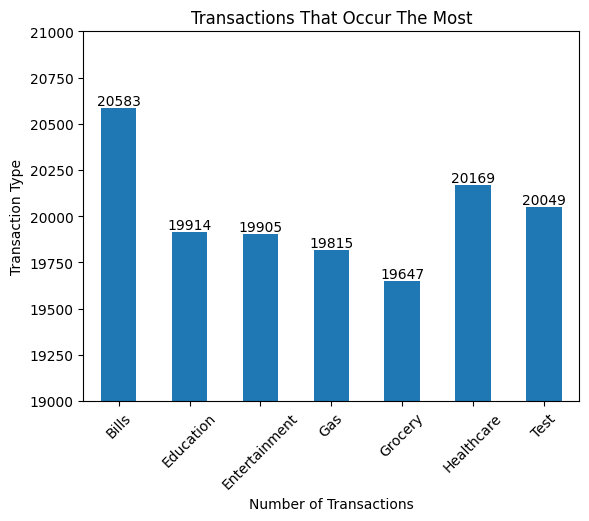

In [72]:
ax = t_type.plot.bar(rot=45)
#ax.set_yticks(list(range(15000, 21000, 1000)))
ax.set_title('Transactions That Occur The Most')
ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Transaction Type')
ax.set_ylim(19000, 21000)
ax.bar_label(ax.containers[0])

plt.savefig('Part3-1.png')

In [73]:
state = cstmr_df.groupby('CUST_STATE')['CUST_STATE'].count()

In [74]:
state

CUST_STATE
AL     15
AR     15
CA    135
CT     42
FL    192
GA    219
IA     63
IL    174
IN     39
KY     51
MA     99
MD    150
MI    132
MN     84
MS     72
MT     27
NC    111
NJ    159
NY    288
OH    132
PA    216
SC     90
TX     99
VA    117
WA     48
WI     87
Name: CUST_STATE, dtype: int64

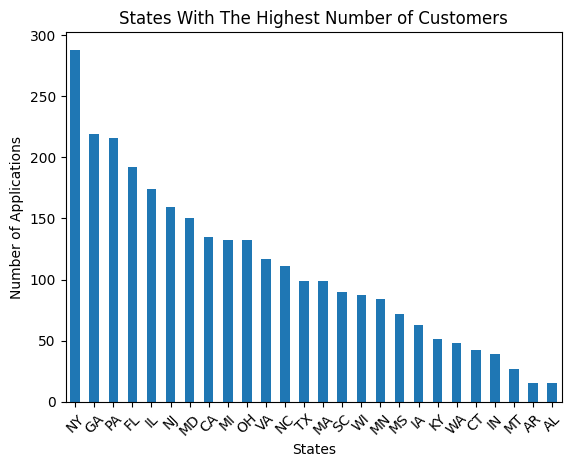

In [75]:
ax = state.sort_values(ascending=False).plot.bar(rot=45)

ax.set_title('States With The Highest Number of Customers')
ax.set_xlabel('States')
ax.set_ylabel('Number of Applications')

plt.savefig('Part3-2.png')

In [76]:
spenders = crdt_df.groupby('CUST_SSN')['TRANSACTION_VALUE'].sum()

In [77]:
spenders = spenders.sort_values(ascending=False).head(20)

In [78]:
spenders

CUST_SSN
123451125    16899.21
123452783    16644.42
123453486    16428.24
123458668    15944.91
123456678    15783.09
123452026    15723.54
123452518    15671.88
123454933    15609.24
123457547    15449.25
123452085    15399.87
123455898    15186.99
123456862    15138.21
123451701    15070.95
123457070    15042.03
123457654    15038.43
123452856    15024.69
123456079    15024.27
123456849    15020.19
123452890    14985.30
123456747    14958.39
Name: TRANSACTION_VALUE, dtype: float64

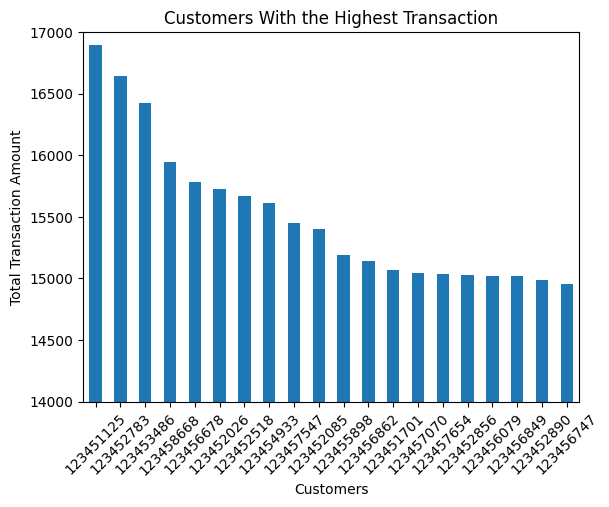

In [79]:
ax = spenders.plot.bar(rot=45)

ax.set_title('Customers With the Highest Transaction')
ax.set_xlabel('Customers')
ax.set_ylabel('Total Transaction Amount')
ax.set_ylim(14000, 17000)

plt.savefig('Part3-3.png')

In [80]:
top_month = crdt_df.groupby(crdt_df['TIMEID'].dt.month)[
    'TRANSACTION_VALUE'].sum()

In [81]:
top_month = top_month.sort_values(ascending=False).head(3)

In [82]:
top_month

TIMEID
10    607751.67
5     603930.78
12    603753.24
Name: TRANSACTION_VALUE, dtype: float64

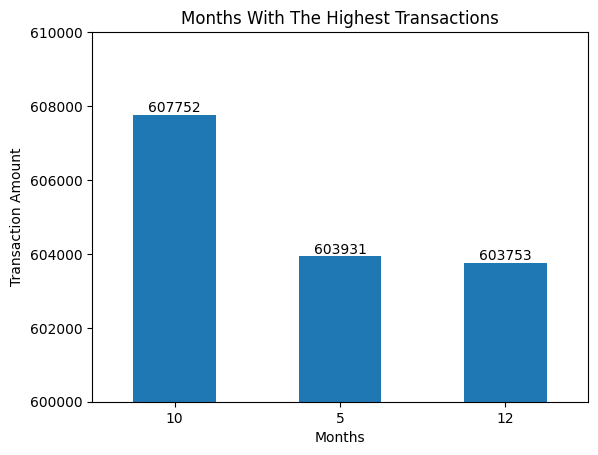

In [83]:
ax = top_month.plot.bar(rot='horizontal')

ax.set_title('Months With The Highest Transactions')
ax.set_xlabel('Months')
ax.set_ylabel('Transaction Amount')
ax.set_ylim(600000, 610000)
ax.bar_label(ax.containers[0])

plt.savefig('Part3-4.png')

In [84]:
healthcare = crdt_df[crdt_df['TRANSACTION_TYPE'] == 'Healthcare']

In [85]:
healthcare = crdt_df.groupby('BRANCH_CODE')['TRANSACTION_VALUE'].sum()

In [86]:
healthcare

BRANCH_CODE
1      54472.71
2      64717.02
3      65249.73
4      61452.12
5      66161.22
         ...   
175    61573.86
178    56904.99
180    60205.41
188    58014.87
192    55100.97
Name: TRANSACTION_VALUE, Length: 114, dtype: float64

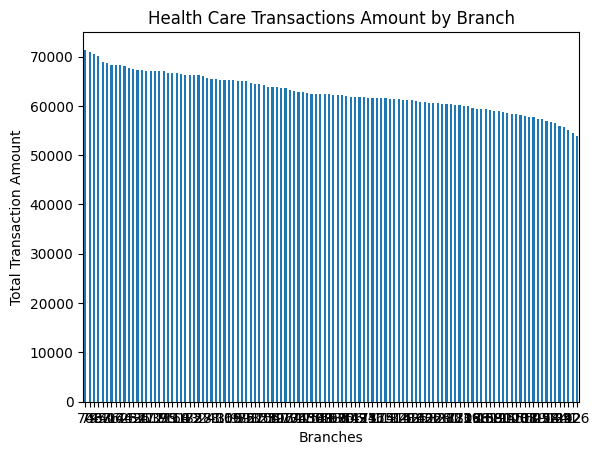

In [87]:
ax = healthcare.sort_values(ascending=False).plot.bar(rot='horizontal')

ax.set_title('Health Care Transactions Amount by Branch')
ax.set_xlabel('Branches')
ax.set_ylabel('Total Transaction Amount')

plt.savefig('Part3-5.png')